In [139]:
# Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta
# Askelmäärä laskettuna kiihtyvyysdatasta Fourier-analyysin perusteella
# Keskinopeus (GPS-datasta)
# Kuljettu matka (GPS-datasta)
# Askelpituus (lasketun askelmäärän ja matkan perusteella)

# Sekä seuraavat kuvaajat: 
# Suodatettu kiihtyvyysdata, jota käytit askelmäärän määrittelemiseen. 
# Analyysiin valitun kiihtyvyysdatan komponentin tehospektritiheys
# Reittisi kartalla

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
import folium 
import imgkit
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
from fpdf import FPDF
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from math import radians, cos, sin, asin, sqrt
from scipy.signal import butter, filtfilt
from streamlit_folium import st_folium

unfilteredStepData = pd.read_csv('data/steps.csv')
unfilteredStepData.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
0,0.033962,-4.845466,4.405187,7.027720
1,0.035181,-4.778467,4.400401,6.982256
2,0.036401,-4.716253,4.400401,6.929615
3,0.037620,-4.646862,4.390830,6.886544
4,0.038839,-4.579863,4.357330,6.843473


In [141]:
unfilteredLocationData = pd.read_csv('data/location.csv')
unfilteredLocationData.head()

locationData = unfilteredLocationData[
    (unfilteredLocationData['Time (s)'] >= 0) 
    #& 
    #(unfilteredLocationData['Time (s)'] <= 110)
    ]


In [142]:
# Kartan piirtäminen

# Määritellään kartan keskipiste ja laajuus (mittakaava / zoomaus)
# Keskipiste on mahdollisimman keskellä liikuttua reittiä

lat_mean = locationData['Latitude (°)'].mean()
long_mean = locationData['Longitude (°)'].mean()

my_map = folium.Map(location = [lat_mean, long_mean], zoom_start=18)
folium.PolyLine(locations = locationData[['Latitude (°)', 'Longitude (°)']].values, color = 'blue', opacity = 0.8).add_to(my_map)

my_map.save('Mapmap.html')
my_map


In [143]:
# kartasta kuva png-muodossa, ensin avataan selain ja sitten tallennetaan kuva
lat_mean = locationData['Latitude (°)'].mean()
long_mean = locationData['Longitude (°)'].mean()

my_map = folium.Map(location=[lat_mean, long_mean], zoom_start=17)
folium.PolyLine(locations=locationData[['Latitude (°)', 'Longitude (°)']].values, color='blue', opacity=0.8).add_to(my_map)

html_file = 'Mapmap.html'
my_map.save(html_file)

options = webdriver.ChromeOptions()
options.add_argument('--headless')  
options.add_argument('--window-size=1200,800')

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
absolute_path = os.path.abspath(html_file)
driver.get(f'file://{absolute_path}')  
time.sleep(2)

driver.save_screenshot('Mapmap.png')
driver.quit()
print("Kuva tallennettu nimellä 'Mapmap.png'")

Kuva tallennettu nimellä 'Mapmap.png'


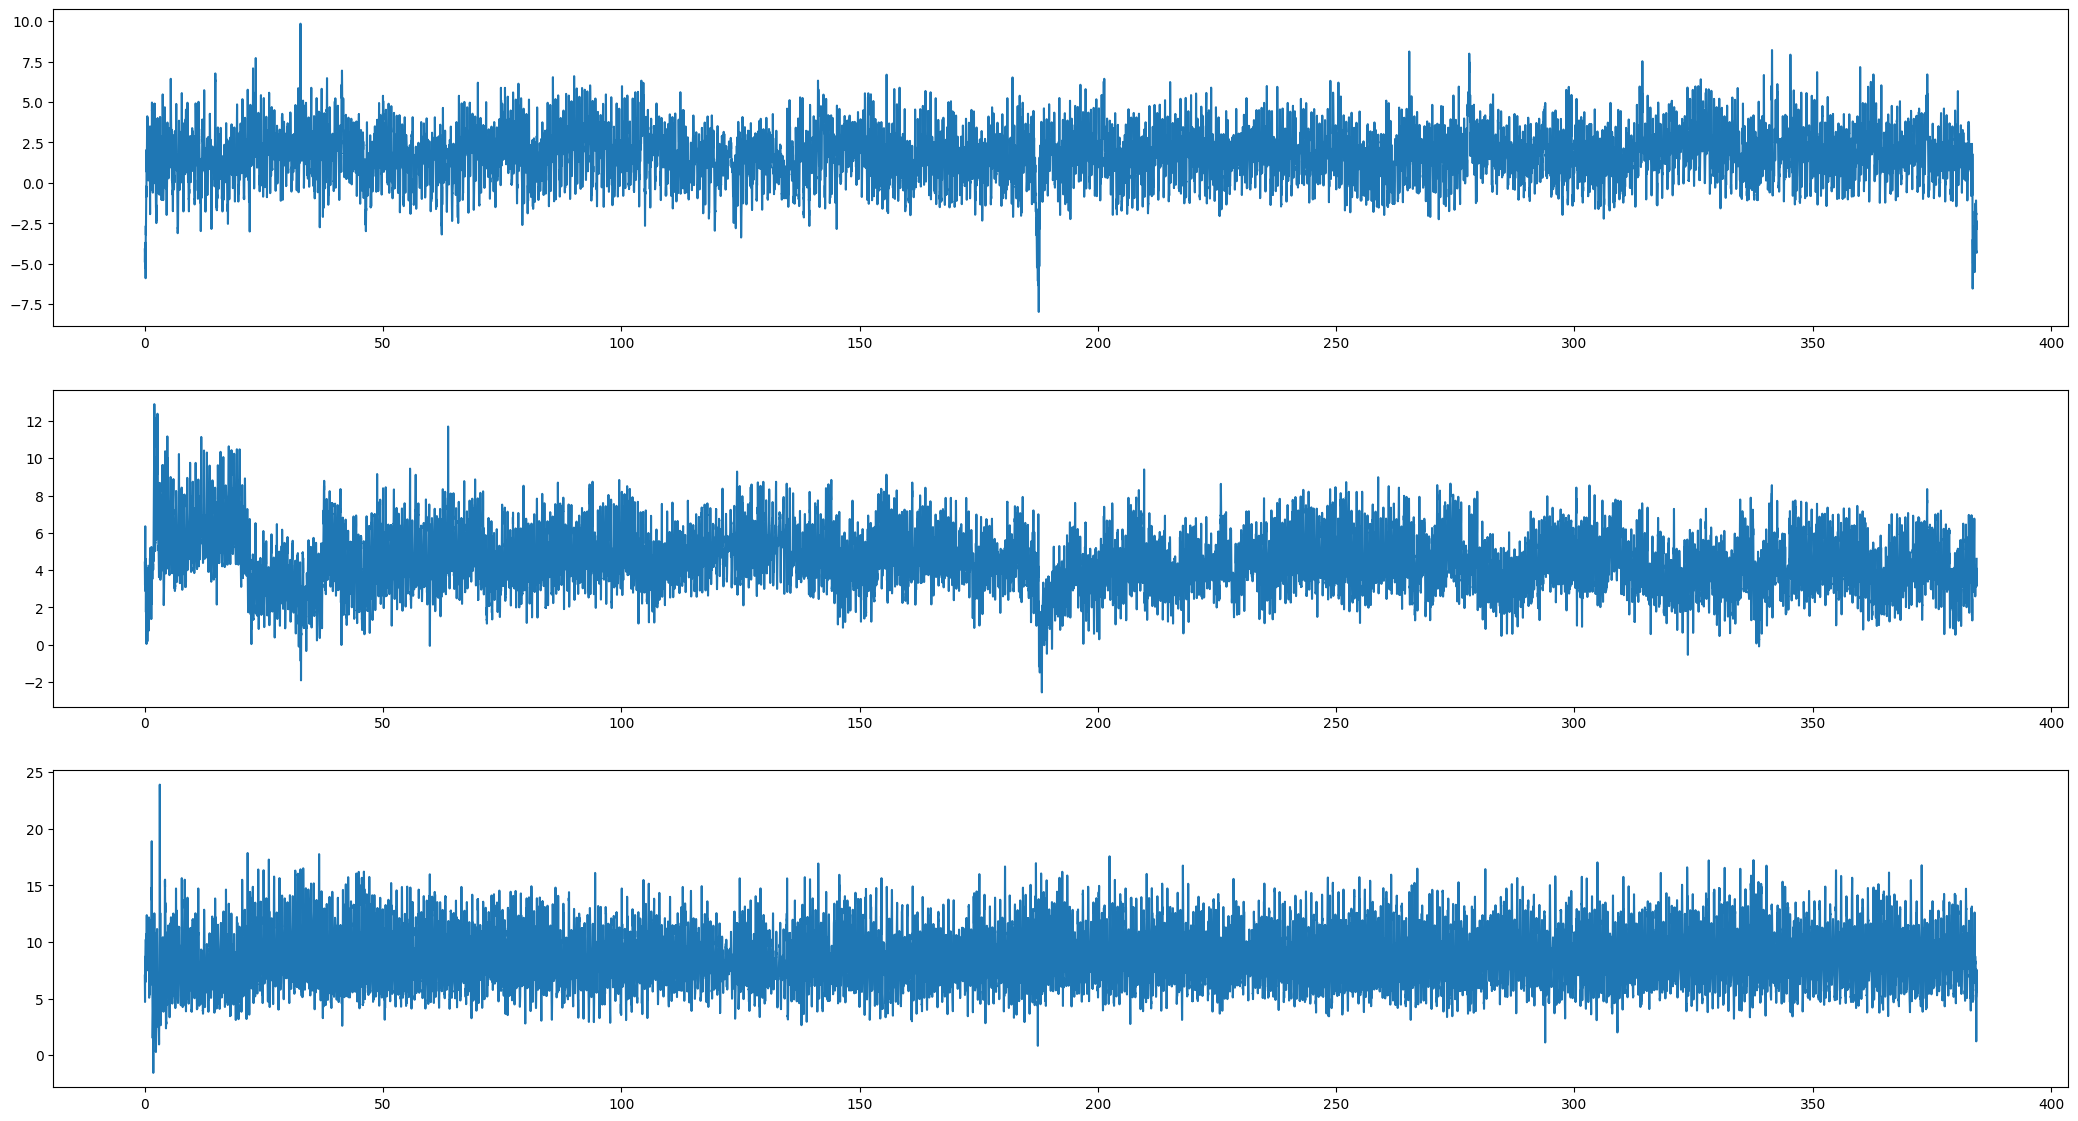

In [144]:

# Askelmäärä suodatetusta kiihtyvyysdatasta (steps.csv)
# Kuvaaja: Suodatettu kiihtyvyysdata, jota käytit askelmäärän määrittelemiseen. 

stepData = unfilteredStepData[
    (unfilteredStepData['Time (s)'] >= 0) 
    #& 
    #(unfilteredStepData['Time (s)'] <= 110)
    ]

stepData.columns

plt.figure(figsize=(26, 14))
plt.subplot(3, 1, 1)
plt.plot(stepData['Time (s)'], stepData['Acceleration x (m/s^2)'])
plt.subplot(3, 1, 2)
plt.plot(stepData['Time (s)'], stepData['Acceleration y (m/s^2)'])
plt.subplot(3, 1, 3)
plt.plot(stepData['Time (s)'], stepData['Acceleration z (m/s^2)'])

plt.show()

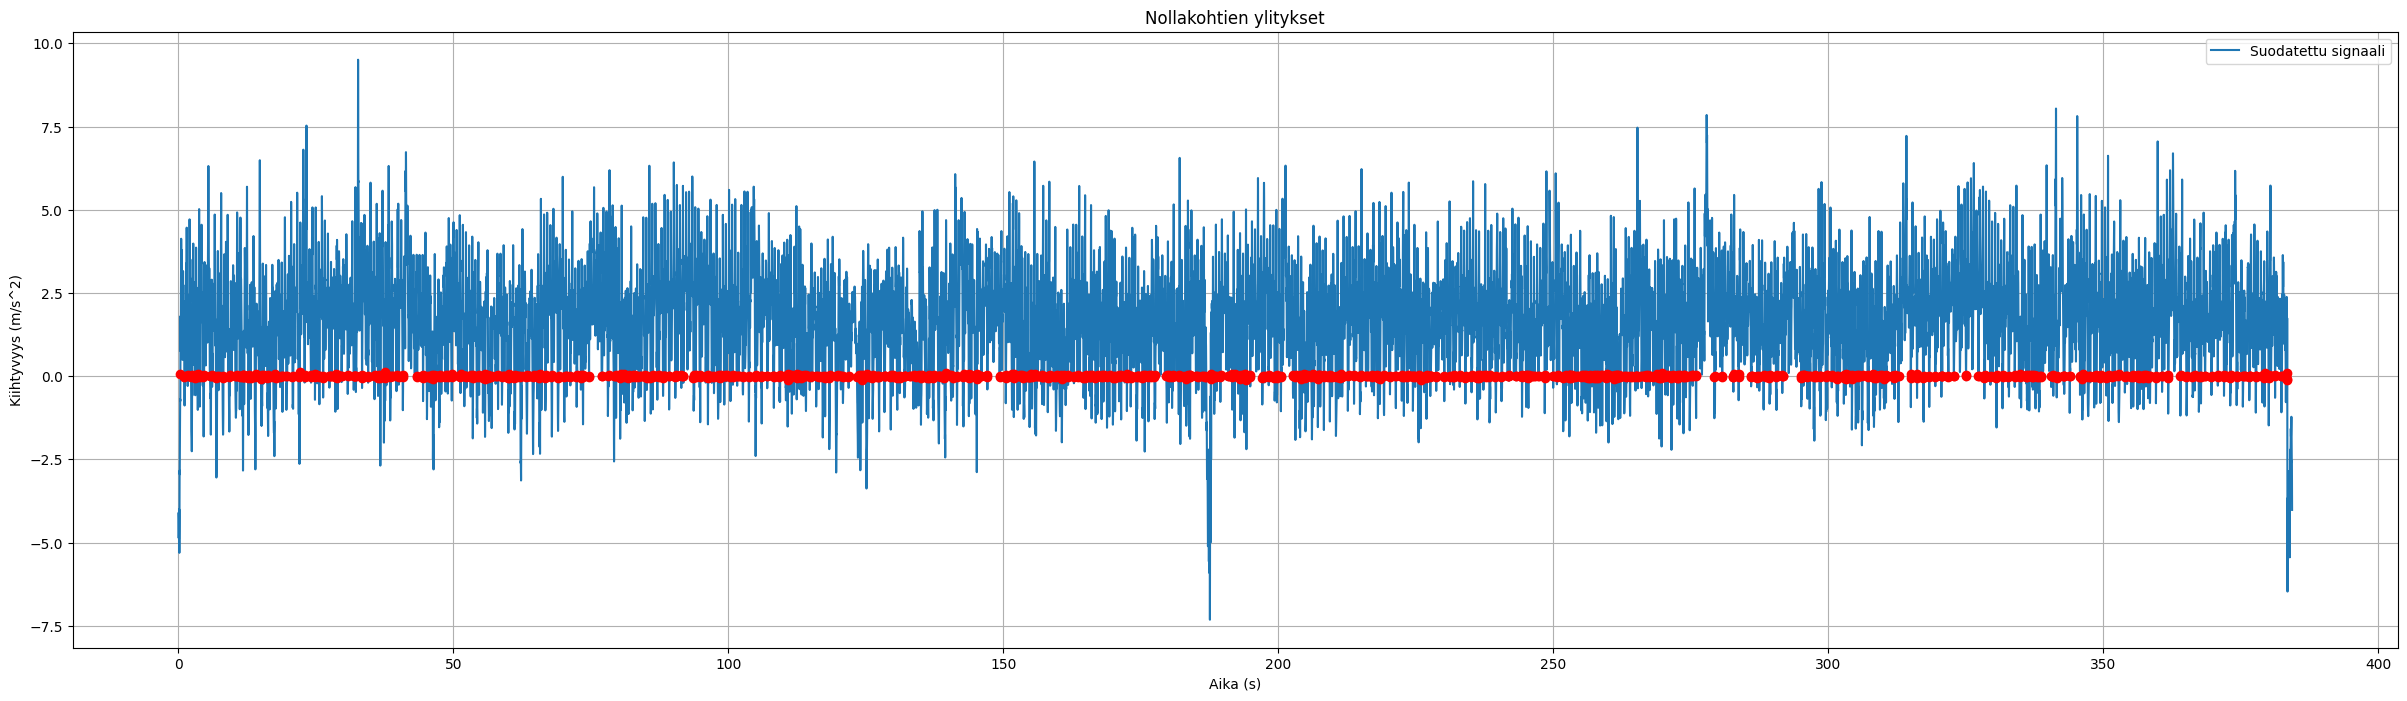

Valittu komponentti X
Suodatettu signaali
Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta:  648.0  askelta


In [145]:

#signaalin suodatus
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    z = filtfilt(b, a, data)
    return z

step_comp = stepData['Acceleration x (m/s^2)']
T = stepData['Time (s)'].iloc[-1] - stepData['Time (s)'].iloc[0]
n = len(stepData['Time (s)'])
fs = n / T
nyq = fs / 2
order = 3
cutoff = 1 / 0.06

filtered_signal = butter_lowpass_filter(step_comp, cutoff, nyq, order)

# nollakohtien ylitys, visualisointi
plt.figure(figsize=(30, 8))
plt.plot(stepData['Time (s)'], filtered_signal, label='Suodatettu signaali')
nollakohtia = 0  
for i in range(1, len(filtered_signal)):
    if (filtered_signal[i-1] > 0 and filtered_signal[i] < 0) or (filtered_signal[i-1] < 0 and filtered_signal[i] > 0):
        nollakohtia += 1
        plt.plot(stepData['Time (s)'].iloc[i], filtered_signal[i], 'ro') 
plt.grid()
plt.xlabel('Aika (s)')
plt.ylabel('Kiihtyvyys (m/s^2)')
plt.title('Nollakohtien ylitykset')
plt.legend()
plt.savefig('zero_crossings.png')
plt.show()

# Askelmäärän laskeminen
# Lasketaan askelten määrä signaalissa nollakohtien avulla
stepCount = np.floor(nollakohtia / 2)  # oletus, että jokaiselle askeleelle on 2 ylitystä

print('Valittu komponentti X')
print('Suodatettu signaali')
print('Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta: ', stepCount, " askelta")


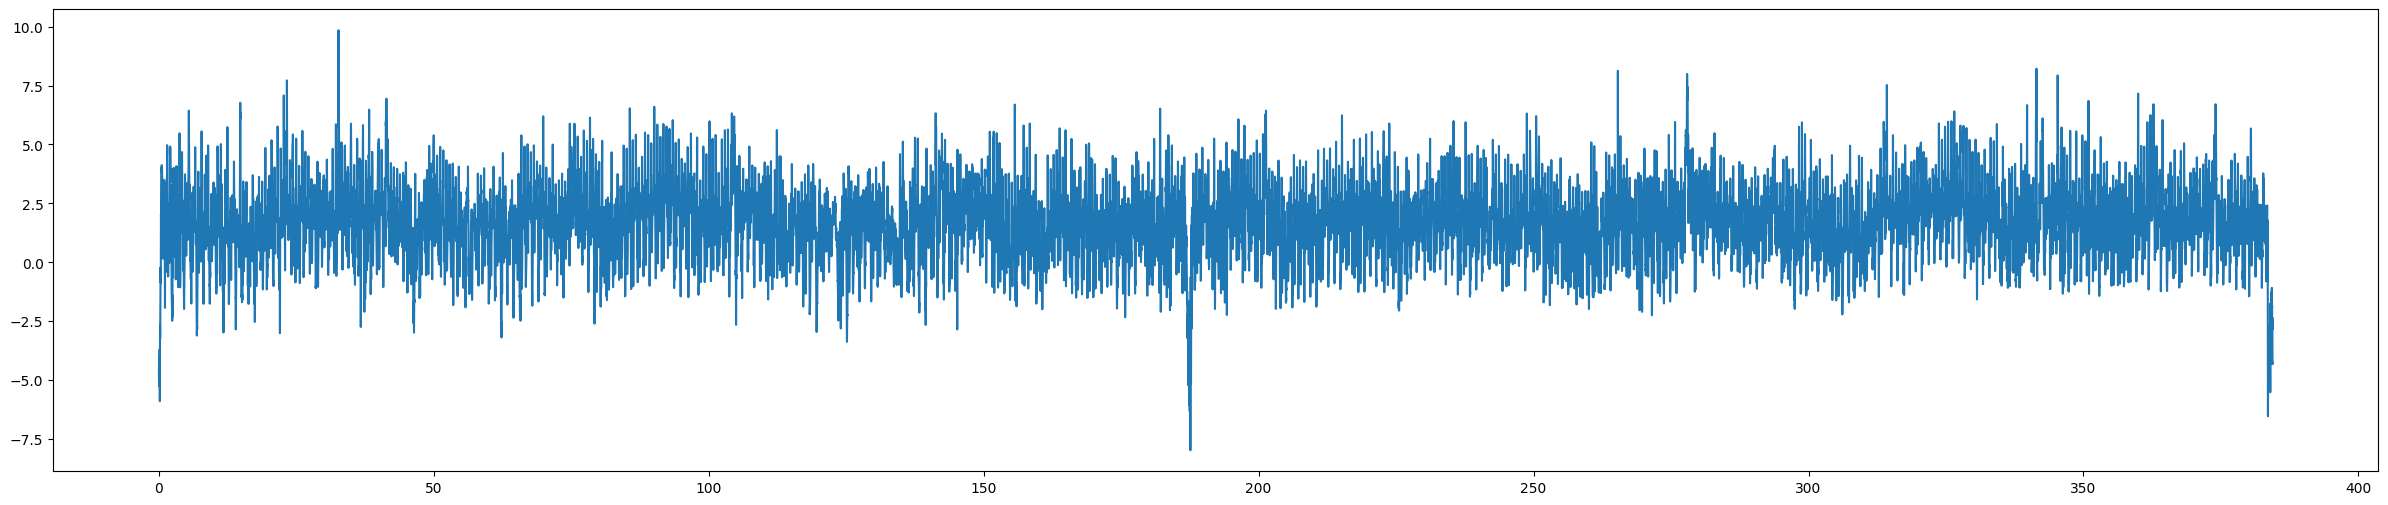

In [146]:
plt.figure(figsize=(30, 6))
plt.plot(stepData['Time (s)'], stepData['Acceleration x (m/s^2)'], label='x')
plt.show()

In [147]:
# Kuljetun matkan pituus, keskinopeus kmh ja askelpituus per askel

lat = locationData['Latitude (°)']
lon = locationData['Longitude (°)']
time = locationData['Time (s)']

def haversine(lon1, lat1, lon2, lat2):
    # degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    # earth radius kilometreinä
    R = 6371.0
    distance = R * c
    return distance

total_distance = 0
for i in range(1, len(locationData)):
    distance = haversine(
        locationData['Longitude (°)'].iloc[i - 1],
        locationData['Latitude (°)'].iloc[i - 1],
        locationData['Longitude (°)'].iloc[i],
        locationData['Latitude (°)'].iloc[i]
    )
    total_distance += distance

estimated_distance = total_distance
distanceInMeters = estimated_distance * 1000

stepLength = distanceInMeters / stepCount
total_time = time.iloc[-1] - time.iloc[0] 
walkingSpeed = (estimated_distance / (total_time / 3600)) 

print(f"Kuljettu matka: {total_distance:.2f} km / {distanceInMeters:.2f} m")
print(f"Askelpituus: {stepLength:.2f} m")
print(f"Keskinopeus: {walkingSpeed:.2f} km/h")

Kuljettu matka: 0.59 km / 594.04 m
Askelpituus: 0.92 m
Keskinopeus: 5.58 km/h


c:\Users\Risu\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Risu\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


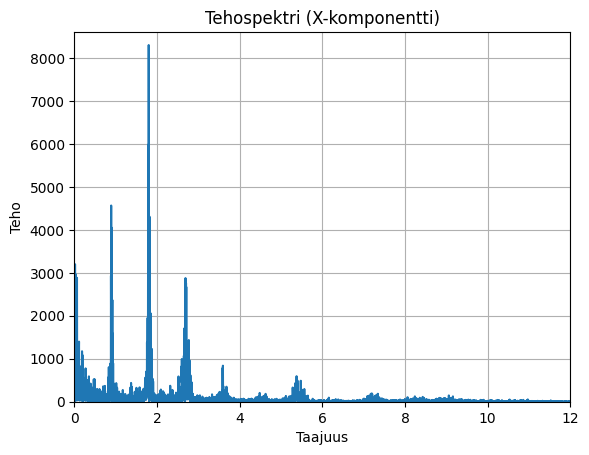

Kävelydatan tehokkain taajuus on 1.7977087119678175 Hz
Tämä vastaa askeleeseen kuluvaa aikaa 0.5562636445730825 s
Tällöin askelten kokonaismäärä on 691.0


In [148]:
f = stepData['Acceleration x (m/s^2)'] #valittu signaali
t = stepData['Time (s)'] #aika
N = len(stepData) # Havaintojen määrä
dt = np.max(t) / len(t) # Oletetaan näytteenottotaajuus vakioksi

fourier = np.fft.fft(f, N) # Fourier-muunnos
psd = fourier*np.conj(fourier) / N  # Tehospektri
freq = np.fft.fftfreq(N, dt) # Taajuudet
L = np.arange(1, int(N/2)) # Rajataan pois nollataajuus ja negatiiviset taajuudet

plt.plot(freq[L], psd[L]) # Piirretään tehospektri
plt.title('Tehospektri (X-komponentti)')
plt.ylabel('Teho')
plt.xlabel('Taajuus')
plt.grid()
plt.axis([0, 12, 0, 8600])
plt.savefig('tehospektri.png')
plt.show()

print('Kävelydatan tehokkain taajuus on', freq[L] [psd[L] == np.max(psd[L])][0], 'Hz' )
print('Tämä vastaa askeleeseen kuluvaa aikaa', 1/freq[L] [psd[L] == np.max(psd[L])][0], 's' )
print('Tällöin askelten kokonaismäärä on', freq[L] [psd[L] == np.max(psd[L])][0]*np.max(t) )

allStepsFourier = freq[L][psd[L] == np.max(psd[L])][0] * np.max(t)


In [149]:
# tallennan kaiken pdf-tiedostoon, koska en saanut streamlitin kanssa toimimaan

pdf = FPDF()

pdf.add_page()
pdf.set_font("Arial", size = 24)
pdf.cell(0, 20, txt = "Fysiikan kurssityö", ln = True, align = 'L')

pdf.set_font("Arial", size = 14)
indentation = 15
indentation2 = 22

pdf.set_font("Arial", size = 16)
pdf.cell(0, 20, txt = "HAVAINNOT", ln = True, align = 'L')

pdf.set_font("Arial", size = 14)
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Askelmäärä suodatetusta kiihtyvyysdatasta", ln = True, align = 'L')
pdf.set_x(indentation2)
pdf.set_font("Arial", style='B', size=14)
pdf.cell(0, 10, txt=f"{stepCount}", ln=True, align='L')
pdf.set_font("Arial", size=14)
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Askelmäärä kiihtyvyysdatasta Fourier-analyysilla", ln = True, align = 'L')
pdf.set_x(indentation2)
pdf.set_font("Arial", style='B', size=14)
pdf.cell(0, 10, txt=f"{allStepsFourier}", ln=True, align='LC')
pdf.set_font("Arial", size=14)
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Keskinopeus (GPS-data)", ln = True, align = 'L')
pdf.set_x(indentation2)
pdf.set_font("Arial", style='B', size=14)
pdf.cell(0, 10, txt=f"{walkingSpeed:.2f} km/h", ln=True)
pdf.set_x(indentation)
pdf.set_font("Arial", size=14)
pdf.cell(0, 10, txt = "Kuljettu matka (GPS-data)", ln = True, align = 'L')
pdf.set_x(indentation2)
pdf.set_font("Arial", style='B', size=14)
pdf.cell(0, 10, txt=f"{distanceInMeters:.2f} m", ln=True)
pdf.set_x(indentation)
pdf.set_font("Arial", size=14)
pdf.cell(0, 10, txt = "Askelpituus (askelmäärän ja matkan perusteella)", ln = True, align = 'L')
pdf.set_x(indentation2)
pdf.set_font("Arial", style='B', size=14)
pdf.cell(0, 10, txt=f"{stepLength:.2f} m", ln=True)

pdf.set_font("Arial", size = 16)
pdf.cell(0, 20, txt = "KUVAAJAT", ln = True, align = 'L')

pdf.set_font("Arial", size = 14)
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Suodatettu kiihtyvyysdata (X-komponentti)", ln = True, align = 'L')
current_y = pdf.get_y() 
pdf.image('filtered_signal.png', x=-10, y=current_y, w=230)
pdf.set_y(current_y + 60) 
pdf.add_page()
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Analyysiin valitun komponentin tehospektritiheys", ln = True, align = 'L')
current_y = pdf.get_y() 
pdf.image('tehospektri.png', x=10, y=current_y, w=160)
pdf.set_y(current_y + 140) 
pdf.set_x(indentation)
pdf.cell(0, 10, txt = "Reitti kartalla", ln = True, align = 'L')
current_y = pdf.get_y() 

image_path = 'Mapmap.png'
with Image.open(image_path) as img:
    img_width, img_height = img.size

aspect_ratio = img_height / img_width
scaled_height = 200 * aspect_ratio
pdf.image(image_path, x=5, y=current_y, w=200, h=scaled_height)

pdf.output('visualization.pdf')

''